## Plotting

In [1]:
import os
os.umask(0o002)

# H5 File bug over network file system.
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

import torch
import torch.nn as nn
from math import sqrt

import torch.nn.functional as F
from models import NetSO2, Net, NetTMBasis, rad_bases, NetC
from ComplexNetsnoTF import *

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)

In [6]:
class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

class ConvNet(nn.Module):
    def __init__(self, layers=6):
        super(ConvNet, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, layers)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
#         print(f'x shape : {x.shape}')
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
#         print(f'out shape : {out.shape}')
        out = torch.add(out,residual)
#         print(f'out shape : {out.shape}')
        return out

mod_SR = ConvNet(12)

In [3]:
# mod_1_10diag = NetTMBasis(TM_name='TheoryTM_MM_28', TM_name_in='TheoryTM_MM_224', Real_in=True, block_diag_mat=10)
# mod_1_5diag = NetTMBasis(TM_name='TheoryTM_MM_28', TM_name_in='TheoryTM_MM_224', Real_in=True, block_diag_mat=5)
# mod_1_full = NetTMBasis(TM_name='TheoryTM_MM_28', TM_name_in='TheoryTM_MM_224', Real_in=True, tm_full_mat=True)
# mod_1 = NetTMBasis(TM_name='TheoryTM_MM_28', TM_name_in='TheoryTM_MM_224', Real_in=True)
mod_mlp = Net(224, 28)
# mod_cmlp = NetC(224, 28)


In [4]:
# checkpoint = torch.load(f'outputs/realmnist_tmbases_v4_SR/mod1_400.tar')
# mod_SR.load_state_dict(checkpoint['model_SR_state_dict'])
# checkpoint = torch.load(f'outputs/realfmnist_tmbases_6000train/mod1_200.tar')
# mod_1.load_state_dict(checkpoint['model_1_state_dict'])
checkpoint = torch.load(f'outputs/realfmnist_mlp_120train/mod1_200.tar')
mod_mlp.load_state_dict(checkpoint['model_1_state_dict'])
# checkpoint = torch.load(f'outputs/realfmnist_cmlp_6000train/mod1_200.tar')
# mod_cmlp.load_state_dict(checkpoint['model_1_state_dict'])

# checkpoint = torch.load(f'outputs/realmnist_tmbases_10_offdiagfibremat/mod1_200.tar')
# mod_1_10diag.load_state_dict(checkpoint['model_1_state_dict'])
# checkpoint = torch.load(f'outputs/realmnist_tmbases_5_offdiagfibremat/mod1_200.tar')
# mod_1_5diag.load_state_dict(checkpoint['model_1_state_dict'])
# checkpoint = torch.load(f'outputs/realmnist_tmbases_fullfibremat/mod1_200.tar')
# mod_1_full.load_state_dict(checkpoint['model_1_state_dict'])


# mod_1.eval()
# mod_SR.eval()
mod_mlp.eval()
# mod_cmlp.eval()

# mod_1_10diag.eval()
# mod_1_5diag.eval()
# mod_1_full.eval()


Net(
  (amp): Amplitude()
  (fc1): Linear(in_features=50176, out_features=784, bias=True)
  (hadamard2): Hadamard2()
)

(6528, 6528)


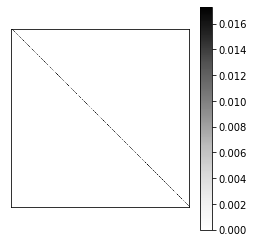

(6528, 6528)


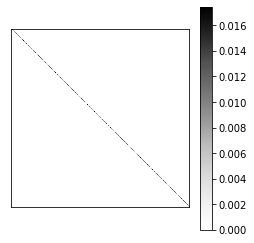

(500, 500)


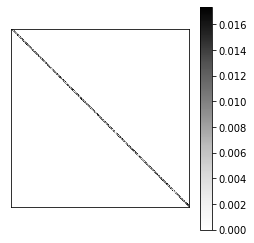

(6528, 6528)


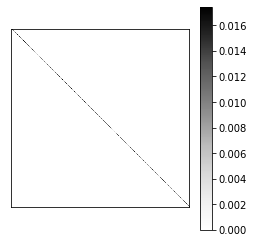

(500, 500)


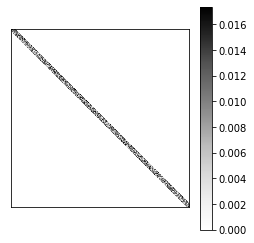

(6528, 6528)
(6528, 6528)


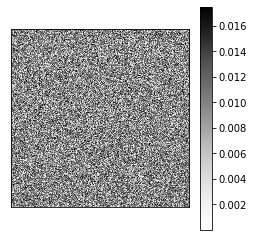

In [24]:
fibre_mat = torch.abs(torch.diag_embed(mod_1.cfc1.weight)).detach().cpu().numpy()
print(fibre_mat.shape)
plt.matshow(fibre_mat, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

for i, w in enumerate(mod_1_5diag.cfc1.weight):
    if i == 0:
        weight = torch.diag_embed(w)
    else:
        w0 = w[0]
        weight = weight + torch.diag_embed(w0, offset=i)
        w1 = w[1]
        weight = weight + torch.diag_embed(w1, offset=-i)
fibre_mat = torch.abs(weight).detach().cpu().numpy()
print(fibre_mat.shape)
plt.matshow(fibre_mat, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

for i, w in enumerate(mod_1_5diag.cfc1.weight):
    if i == 0:
        weight = torch.diag_embed(w)
    else:
        w0 = w[0]
        weight = weight + torch.diag_embed(w0, offset=i)
        w1 = w[1]
        weight = weight + torch.diag_embed(w1, offset=-i)
fibre_mat = torch.abs(weight).detach().cpu().numpy()
fibre_mat = fibre_mat[:500,:500]
print(fibre_mat.shape)
plt.matshow(fibre_mat, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

for i, w in enumerate(mod_1_10diag.cfc1.weight):
    if i == 0:
        weight = torch.diag_embed(w)
    else:
        w0 = w[0]
        weight = weight + torch.diag_embed(w0, offset=i)
        w1 = w[1]
        weight = weight + torch.diag_embed(w1, offset=-i)
fibre_mat = torch.abs(weight).detach().cpu().numpy()
print(fibre_mat.shape)
plt.matshow(fibre_mat, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

for i, w in enumerate(mod_1_10diag.cfc1.weight):
    if i == 0:
        weight = torch.diag_embed(w)
    else:
        w0 = w[0]
        weight = weight + torch.diag_embed(w0, offset=i)
        w1 = w[1]
        weight = weight + torch.diag_embed(w1, offset=-i)
fibre_mat = torch.abs(weight).detach().cpu().numpy()
fibre_mat = fibre_mat[:500,:500]
print(fibre_mat.shape)
plt.matshow(fibre_mat, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

fibre_mat = torch.abs(mod_1_full.cfc1.weight).detach().cpu().numpy()
print(fibre_mat.shape)
print(fibre_mat.shape)
plt.matshow(fibre_mat, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

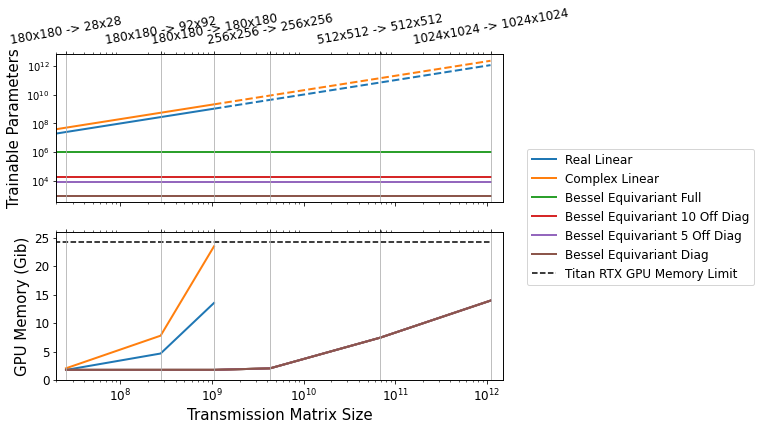

In [127]:
TM_size      = [90*90*28*28,   180*180*28*28,   180*180*92*92,   180**4,   255**4,   512**4,   1024**4]
mlp          = [90*90*28*28,   180*180*28*28,   180*180*92*92,   180**4,   255**4,   512**4,   1024**4]
cmlp         = [90*90*28*28*2, 180*180*28*28*2, 180*180*92*92*2, 2*180**4, 2*255**4, 2*512**4, 2*1024**4]
mod_1        = [1000,    1000,    1000,    1000,    1000,    1000,    1000]
mod_1_5diag  = [8980,    8980,    8980,    8980,    8980,    8980,    8980]
mod_1_10diag = [18910,   18910,   18910,   18910,   18910,   18910,   18910]
mod_1_full   = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]

fig, (ax0, ax1) = plt.subplots(figsize=(8,6), nrows=2, sharex=True)
ax0.plot(TM_size[:4], mlp[:4], label='Real Linear', color='C0', lw=2)
ax0.plot(TM_size[:4], cmlp[:4], label='Complex Linear', color='C1', lw=2)
ax0.plot(TM_size[3:], mlp[3:], color='C0', linestyle='dashed', lw=2)
ax0.plot(TM_size[3:], cmlp[3:], color='C1', linestyle='dashed', lw=2)
ax0.plot(TM_size, mod_1_full, label='Bessel Equivariant Full', color='C2', lw=2)
ax0.plot(TM_size, mod_1_10diag, label='Bessel Equivariant 10 Off Diag', color='C3', lw=2)
ax0.plot(TM_size, mod_1_5diag, label='Bessel Equivariant 5 Off Diag', color='C4', lw=2)
ax0.plot(TM_size, mod_1, label='Bessel Equivariant Diag', color='C5', lw=2)
# plt.plot([180*180*28*28, 256*256*256*256], [24.2, 24.2], 'k--', label='Titan RTX GPU Memory Limit')
# plt.plot([180*180*28*28, 180*180*28*28], [1000, 255*255*255*255], 'k--')
ax0.set_xlim(2*10**7,1.5*10**12)
ax0.set_xscale('log')
ax0.set_yscale('log')
# ax0.set_xlabel(f'Transmission Matrix Size', fontsize=15)
ax0.set_ylabel(f'Trainable Parameters', fontsize=15)
# plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(loc='right', fontsize=12)
ax2 = ax0.twiny()
# ax2.set_xlim(180*180*28*28,256*256*256*256)
ax2.set_xscale('log')
ax2.set_xticks([180*180*28*28, 180*180*92*92, 180**4, 256**4, 512**4, 1024**4])
ax2.set_xticklabels([f'180x180 -> 28x28', f'180x180 -> 92x92', f'180x180 -> 180x180', f'256x256 -> 256x256', f'512x512 -> 512x512', f'1024x1024 -> 1024x1024'], rotation=10, fontsize=12)
ax2.grid(axis='both', which='major')
ax2.set_xlim(2*10**7,1.5*10**12)

TM_size      = np.array([180*180*28*28,   180*180*92*92,   180*180*180*180,   256*256*256*256])
mlp          = np.array([1800,            4680,            13546,             0]) /1000
cmlp         = np.array([2088,            7808,            23470,             0]) /1000

TM_size2     = np.array([180*180*28*28,   180**4, 256**4, 512**4, 1024**4])
mod_1        = np.array([1810,            1812,   2078,   7464,   13960]) /1000
mod_1_5diag  = np.array([1810,            1812,   2078,   7464,   13960]) /1000
mod_1_10diag = np.array([1810,            1812,   2078,   7464,   13960]) /1000
mod_1_full   = np.array([1810,            1812,   2078,   7464,   13960]) /1000

ax1.plot(TM_size[:3], mlp[:3],  label='Real Linear', color='C0', lw=2)
ax1.plot(TM_size[:3], cmlp[:3], label='Complex Linear', color='C1', lw=2)
ax1.plot(TM_size2, mod_1_full,  label='Bessel Equivariant Full', color='C2', lw=2)
ax1.plot(TM_size2, mod_1_10diag, label='Bessel Equivariant 10 Off Diag', color='C3', lw=2)
ax1.plot(TM_size2, mod_1_5diag,  label='Bessel Equivariant 5 Off Diag', color='C4', lw=2)
ax1.plot(TM_size2, mod_1, label='Bessel Equivariant Diag', color='C5', lw=2)
ax1.plot([0, 1024**4], [24.2, 24.2], 'k--', label='Titan RTX GPU Memory Limit')
ax1.set_ylim(0,26)
ax1.set_xlim(2*10**7,1.5*10**12)
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_ylabel(f'GPU Memory (Gib)', fontsize=15)
ax1.set_xlabel(f'Transmission Matrix Size', fontsize=15)
ax3 = ax1.twiny()
ax3.set_xscale('log')
ax3.set_xticks([180*180*28*28, 180*180*92*92, 180**4, 256**4, 512**4, 1024**4])
ax3.set_xticklabels([], rotation=10, fontsize=12)
# ax3.set_xticklabels([f'180x180 -> 28x28', f'180x180 -> 92x92', f'180x180 -> 180x180', f'256x256 -> 256x256', f'512x512 -> 512x512', f'1024x1024 -> 1024x1024'], rotation=10, fontsize=12)
ax3.grid(axis='both', which='major')
ax3.set_xlim(2*10**7,1.5*10**12)

ax1.legend(bbox_to_anchor=(1.04,0.6), loc="lower left", fontsize=12)

plt.savefig(f'outputs/figures/scalability_shared.pdf', bbox_inches="tight")
plt.savefig(f'outputs/figures/scalability_shared.png', bbox_inches="tight")
plt.show()

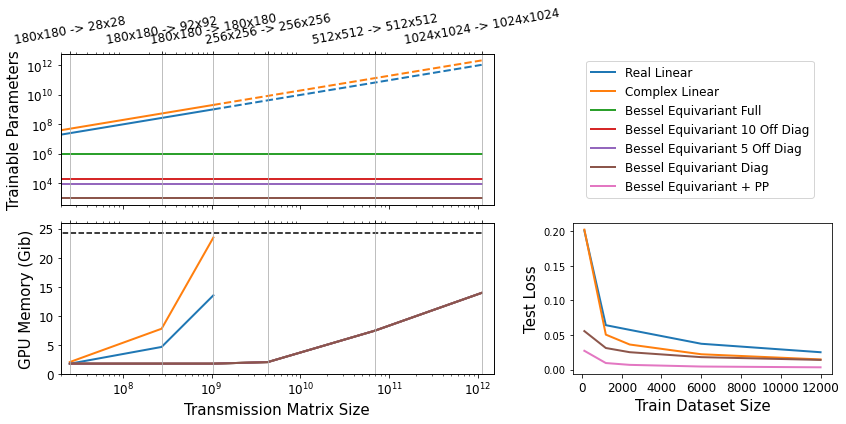

In [58]:
TM_size      = [90*90*28*28,   180*180*28*28,   180*180*92*92,   180**4,   255**4,   512**4,   1024**4]
mlp          = [90*90*28*28,   180*180*28*28,   180*180*92*92,   180**4,   255**4,   512**4,   1024**4]
cmlp         = [90*90*28*28*2, 180*180*28*28*2, 180*180*92*92*2, 2*180**4, 2*255**4, 2*512**4, 2*1024**4]
mod_1        = [1000,    1000,    1000,    1000,    1000,    1000,    1000]
mod_1_5diag  = [8980,    8980,    8980,    8980,    8980,    8980,    8980]
mod_1_10diag = [18910,   18910,   18910,   18910,   18910,   18910,   18910]
mod_1_full   = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]

TrainSize    = np.array([12000, 6000,  2400,    1200,    120])
mlp_rd       = np.array([0.0250, 0.03724, 0.05733, 0.06410, 0.20094])
cmlp_rd      = np.array([0.0146, 0.02207, 0.03615, 0.05043, 0.20212])
mod_1_rd     = np.array([0.0139, 0.01789, 0.02504, 0.03110, 0.05554])
mod_1_sr_rd  = np.array([0.0032, 0.00433, 0.00675, 0.00938, 0.02708])

# fig, ((ax0, ax1), (ax4, ax5)) = plt.subplots(figsize=(8,6), nrows=2, ncols=2, sharex=True)
fig, ((ax0, ax1), (ax4, ax5)) = plt.subplots(figsize=(12,6), nrows=2, ncols=2, gridspec_kw={'width_ratios':[5,3]})
ax0.plot(TM_size[:4], mlp[:4], label='Real Linear', color='C0', lw=2)
ax0.plot(TM_size[:4], cmlp[:4], label='Complex Linear', color='C1', lw=2)
ax0.plot(TM_size[3:], mlp[3:], color='C0', linestyle='dashed', lw=2)
ax0.plot(TM_size[3:], cmlp[3:], color='C1', linestyle='dashed', lw=2)
ax0.plot(TM_size, mod_1_full, label='Bessel Equivariant Full', color='C2', lw=2)
ax0.plot(TM_size, mod_1_10diag, label='Bessel Equivariant 10 Off Diag', color='C3', lw=2)
ax0.plot(TM_size, mod_1_5diag, label='Bessel Equivariant 5 Off Diag', color='C4', lw=2)
ax0.plot(TM_size, mod_1, label='Bessel Equivariant Diag', color='C5', lw=2)
# plt.plot([180*180*28*28, 256*256*256*256], [24.2, 24.2], 'k--', label='Titan RTX GPU Memory Limit')
# plt.plot([180*180*28*28, 180*180*28*28], [1000, 255*255*255*255], 'k--')
ax0.set_xlim(2*10**7,1.5*10**12)
ax0.set_xscale('log')
ax0.set_yscale('log')
# ax0.set_xlabel(f'Transmission Matrix Size', fontsize=15)
ax0.set_ylabel(f'Trainable Parameters', fontsize=15)
# plt.grid()
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax0.xaxis.set_tick_params(labelsize=12)
ax0.yaxis.set_tick_params(labelsize=12)
ax0.set_xticklabels([], fontsize=12)
# plt.legend(loc='right', fontsize=12)
ax2 = ax0.twiny()
# ax2.set_xlim(180*180*28*28,256*256*256*256)
ax2.set_xscale('log')
ax2.set_xticks([180*180*28*28, 180*180*92*92, 180**4, 256**4, 512**4, 1024**4])
ax2.set_xticklabels([f'180x180 -> 28x28', f'180x180 -> 92x92', f'180x180 -> 180x180', f'256x256 -> 256x256', f'512x512 -> 512x512', f'1024x1024 -> 1024x1024'], rotation=10, fontsize=12)
ax2.grid(axis='both', which='major')
ax2.set_xlim(2*10**7,1.5*10**12)

TM_size      = np.array([180*180*28*28,   180*180*92*92,   180*180*180*180,   256*256*256*256])
mlp          = np.array([1800,            4680,            13546,             0]) /1000
cmlp         = np.array([2088,            7808,            23470,             0]) /1000

TM_size2     = np.array([180*180*28*28,   180**4, 256**4, 512**4, 1024**4])
mod_1        = np.array([1810,            1812,   2078,   7464,   13960]) /1000
mod_1_5diag  = np.array([1810,            1812,   2078,   7464,   13960]) /1000
mod_1_10diag = np.array([1810,            1812,   2078,   7464,   13960]) /1000
mod_1_full   = np.array([1810,            1812,   2078,   7464,   13960]) /1000

ax4.plot(TM_size[:3], mlp[:3],  label='Real Linear', color='C0', lw=2)
ax4.plot(TM_size[:3], cmlp[:3], label='Complex Linear', color='C1', lw=2)
ax4.plot(TM_size2, mod_1_full,  label='Bessel Equivariant Full', color='C2', lw=2)
ax4.plot(TM_size2, mod_1_10diag, label='Bessel Equivariant 10 Off Diag', color='C3', lw=2)
ax4.plot(TM_size2, mod_1_5diag,  label='Bessel Equivariant 5 Off Diag', color='C4', lw=2)
ax4.plot(TM_size2, mod_1, label='Bessel Equivariant Diag', color='C5', lw=2)
ax4.plot([0, 1024**4], [24.2, 24.2], 'k--', label='Titan RTX GPU Memory Limit')
ax4.set_ylim(0,26)
ax4.set_xlim(2*10**7,1.5*10**12)
ax4.set_xscale('log')
# ax1.set_yscale('log')
ax4.set_ylabel(f'GPU Memory (Gib)', fontsize=15)
ax4.set_xlabel(f'Transmission Matrix Size', fontsize=15)
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)
ax3 = ax4.twiny()
ax3.set_xscale('log')
ax3.set_xticks([180*180*28*28, 180*180*92*92, 180**4, 256**4, 512**4, 1024**4])
ax3.set_xticklabels([], rotation=10, fontsize=12)
# ax3.set_xticklabels([f'180x180 -> 28x28', f'180x180 -> 92x92', f'180x180 -> 180x180', f'256x256 -> 256x256', f'512x512 -> 512x512', f'1024x1024 -> 1024x1024'], rotation=10, fontsize=12)
ax3.grid(axis='both', which='major')
ax3.set_xlim(2*10**7,1.5*10**12)

ax1.set_axis_off()

ax5.plot(TrainSize, mlp_rd,  label='Real Linear', color='C0', lw=2)
ax5.plot(TrainSize, cmlp_rd, label='Complex Linear', color='C1', lw=2)
ax5.plot(TrainSize, mod_1_rd,  label='Bessel Equivariant', color='C5', lw=2)
ax5.plot(TrainSize, mod_1_sr_rd,  label='Bessel Equivariant + PP', color='C6', lw=2)

ax5.set_xlabel(f'Train Dataset Size', fontsize=15)
ax5.set_ylabel(f'Test Loss', fontsize=15)
ax5.xaxis.set_tick_params(labelsize=12)
ax5.xaxis.set_tick_params(labelsize=12)
# ax5.set_xticks(fontsize=12)
# ax5.set_yticks(fontsize=12)

plt.tight_layout()

handles, labels = ax0.get_legend_handles_labels()
handles2, labels2 = ax5.get_legend_handles_labels()
handles.append(handles2[-1])
labels.append(labels2[-1])
# print(handles)
# print(labels)

# ax0.legend(bbox_to_anchor=(1.04,0.6), loc="center left", fontsize=12)
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax0.legend(handles, labels, bbox_to_anchor=(1.2,0.5), loc="center left", fontsize=12)

plt.savefig(f'outputs/figures/scalability_red_data.pdf', bbox_inches="tight")
plt.savefig(f'outputs/figures/scalability_red_data.png', bbox_inches="tight")
plt.show()

In [5]:
data_path = f'data/Real_fmnist/'
file_location = f'test_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_test = np.array(f['original'])
    speckled_imgs_test = np.array(f['speckled'], dtype=np.single) / (255.0 * 1)
#     speckled_imgs_test = np.array(f['speckled'], dtype=np.csingle)
#     inverted_imgs_test = np.array(f['inverted'], dtype=np.csingle)
    
print(original_imgs_test.shape)
original_imgs_max = np.max(original_imgs_test)
original_imgs_min = np.min(original_imgs_test)
speckled_imgs_max = np.max(np.abs(speckled_imgs_test))
speckled_imgs_min = np.min(np.abs(speckled_imgs_test))
print(f'original_imgs_max : {original_imgs_max}')
print(f'original_imgs_min : {original_imgs_min}')
print(f'speckled_imgs_max : {speckled_imgs_max}')
print(f'speckled_imgs_min : {speckled_imgs_min}')

Keys: <KeysViewHDF5 ['original', 'speckled']>
(3000, 28, 28)
original_imgs_max : 1.0
original_imgs_min : 0.0
speckled_imgs_max : 1.0
speckled_imgs_min : 0.003921568859368563


In [6]:
data_path = f'data/Real_fmnist/'
file_location = f'train_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_train = np.array(f['original'])[:120]
    speckled_imgs_train = np.array(f['speckled'], dtype=np.single) / (255.0 * 1)
    speckled_imgs_train = speckled_imgs_train[:120]
    
print(original_imgs_train.shape)


Keys: <KeysViewHDF5 ['original', 'speckled']>
(120, 28, 28)


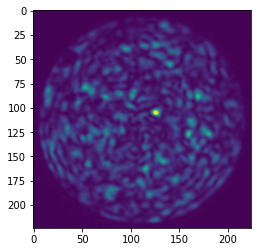

In [7]:
plt.imshow(np.abs(speckled_imgs_test[2]))

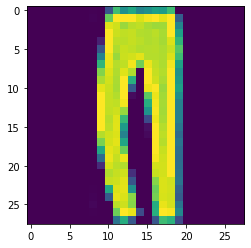

In [8]:
plt.imshow(original_imgs_test[2])

In [9]:
# mod_1 = mod_1.cuda()
# mod_SR = mod_SR.cuda()
mod_mlp = mod_mlp.cuda()
# mod_cmlp = mod_cmlp.cuda()


In [11]:
print(f'Trainable params (mil) : {sum(p.numel() for p in mod_mlp.parameters() if p.requires_grad)/1000000}')
print(f'Params (mil) : {sum(p.numel() for p in mod_mlp.parameters())/1000000}')

# print(f'Trainable params (mil) : {sum(p.numel() for p in mod_cmlp.parameters() if p.requires_grad)/1000000}')
# print(f'Params (mil) : {sum(p.numel() for p in mod_cmlp.parameters())/1000000}')

# print(f'Trainable params (mil) : {sum(p.numel() for p in mod_1.parameters() if p.requires_grad)/1000000}')
# print(f'Params (mil) : {sum(p.numel() for p in mod_1.parameters())/1000000}')

# print(f'Trainable params (mil) : {sum(p.numel() for p in mod_SR.parameters() if p.requires_grad)/1000000}')
# print(f'Params (mil) : {sum(p.numel() for p in mod_SR.parameters())/1000000}')



Trainable params (mil) : 39.339552
Params (mil) : 39.339552


In [12]:
tot_loss = 0
for original_img, speckled_img in zip(original_imgs_test,speckled_imgs_test):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_mlp(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
#     predicted_img = predicted_img.view(-1,1,28,28)
#     predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.027738896186463535


In [22]:
tot_loss = 0
for original_img, speckled_img in zip(original_imgs_test,speckled_imgs_test):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_cmlp(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
#     predicted_img = predicted_img.view(-1,1,28,28)
#     predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.021464197567198424


In [23]:
tot_loss = 0
for original_img, speckled_img in zip(original_imgs_test,speckled_imgs_test):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
#     predicted_img = predicted_img.view(-1,1,28,28)
#     predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

# tot_loss = 0
# for original_img, speckled_img in zip(original_imgs_train,speckled_imgs_train):
#     original_img = torch.from_numpy(original_img).cuda()
#     original_img = torch.unsqueeze(original_img, dim=0)
#     original_img = torch.unsqueeze(original_img, dim=1)
#     speckled_img = torch.from_numpy(speckled_img).cuda()
#     speckled_img = torch.unsqueeze(speckled_img, dim=0)
#     speckled_img = torch.unsqueeze(speckled_img, dim=1)

#     speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
#     ## Pass image through model
#     predicted_inv_img = mod_1(speckled_img)
#     predicted_img = torch.abs(predicted_inv_img)
    
# #     predicted_img = predicted_img.view(-1,1,28,28)
# #     predicted_img = mod_SR(predicted_img)

#     original_img = original_img.view(1,-1)
#     predicted_img = predicted_img.view(1,-1)

#     loss = F.mse_loss(predicted_img, original_img)
#     tot_loss += loss.item()
# print(tot_loss/len(speckled_imgs_train))

0.035567390162187316


In [26]:
tot_loss = 0
for original_img, speckled_img in zip(original_imgs_test,speckled_imgs_test):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
    predicted_img = predicted_img.view(-1,1,28,28)
    predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

tot_loss = 0
for original_img, speckled_img in zip(original_imgs_train,speckled_imgs_train):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
    predicted_img = predicted_img.view(-1,1,28,28)
    predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

0.009639004443694527
0.0030587431674163478


predicted_inv_img_mlp : 1.2222994565963745
predicted_inv_img_mlp : 0.741331934928894
predicted_inv_img_mlp : 0.6526774764060974
predicted_inv_img_mlp : 0.5262168645858765
predicted_inv_img_mlp : 0.31421729922294617
predicted_inv_img_mlp : 0.5734443068504333
predicted_inv_img_mlp : 1.0216224193572998


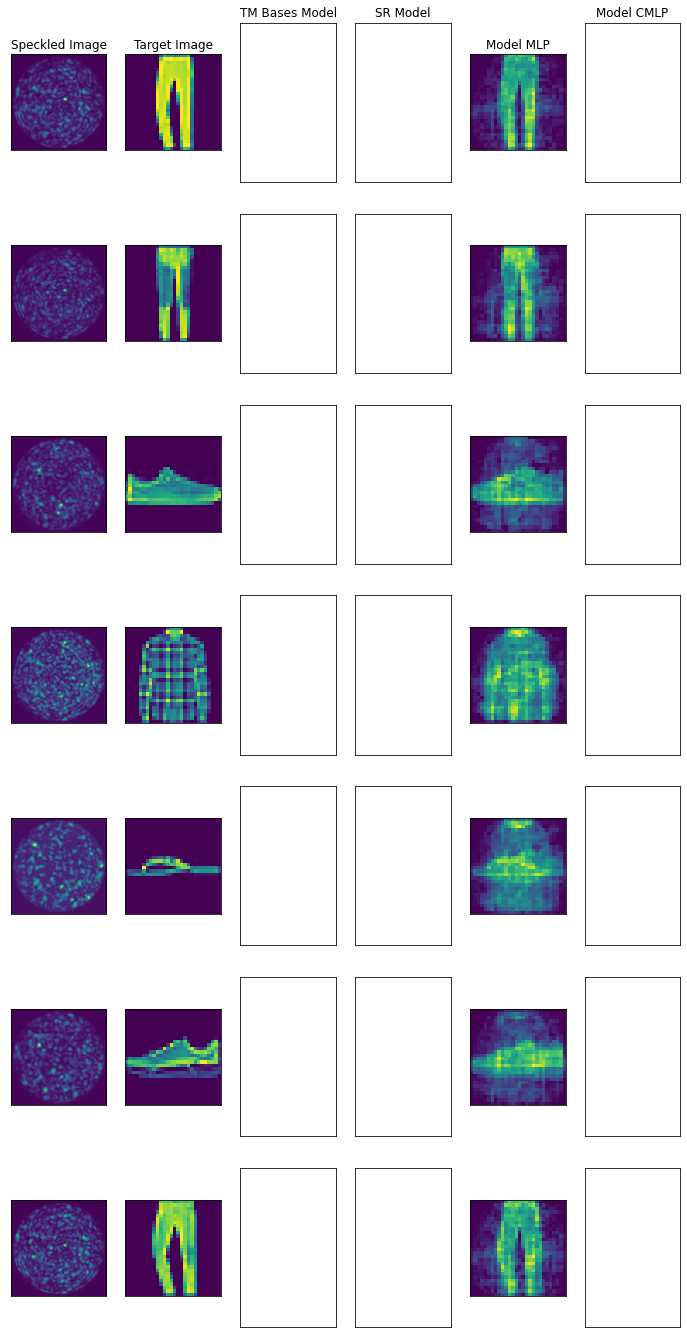

In [13]:
img_nums = [2,3,12,7,8,9,5]
f, ax_arr = plt.subplots(len(img_nums), 5, figsize=(12,24))
for i, img_num in enumerate(img_nums):
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=0)

    speckled_img = torch.unsqueeze(speckled_img, dim=1)
    original_img = torch.unsqueeze(original_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)

    ## Pass image through model
#     predicted_inv_img = mod_1(speckled_img)
#     predicted_inv_img = torch.abs(predicted_inv_img)
    
#     predicted_inv_img = predicted_inv_img.view(-1,1,28,28)
#     predicted_img = mod_SR(predicted_inv_img)#.cpu()
    
    predicted_inv_img_mlp = mod_mlp(speckled_img)
#     predicted_inv_img_cmlp = mod_cmlp(speckled_img)
    
#     original_img = original_img.cpu()
#     speckled_img = speckled_img.cpu()
    
    speckled_img = speckled_img.view(224,224).detach().cpu().numpy()
    original_img = original_img.view(28,28).detach().cpu().numpy()
#     predicted_inv_img = predicted_inv_img.view(28,28).detach().cpu().numpy()
#     predicted_img = predicted_img.view(28,28).detach().cpu().numpy()
    predicted_inv_img_mlp = predicted_inv_img_mlp.view(28,28).detach().cpu().numpy()
#     predicted_inv_img_cmlp = predicted_inv_img_cmlp.view(28,28).detach().cpu().numpy()

    
#     f, ax_arr = plt.subplots(1, 3, figsize=(20, 13))
    plt.subplot(len(img_nums), 6, 1 + (i*6))
#     plt.imshow(inverted_img.view(256,256).detach().cpu().numpy(), cmap='gray_r')
    plt.imshow(np.abs(speckled_img))
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Speckled Image')
    plt.subplot(len(img_nums), 6, 2 + (i*6))
#     plt.imshow(original_img.view(256,256).detach().cpu().numpy(), cmap='gray_r')
    plt.imshow(original_img)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Target Image')
    plt.subplot(len(img_nums), 6, 3 + (i*6))
#     plt.imshow(predicted_img.view(256,256).detach().cpu().numpy(), cmap='gray_r')
#     plt.imshow(np.abs(predicted_inv_img), vmin=np.min(np.abs(predicted_inv_img)), vmax=np.max(np.abs(predicted_inv_img)))
#     plt.imshow(np.abs(predicted_inv_img))
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'TM Bases Model')
    plt.subplot(len(img_nums), 6, 4 + (i*6))
#     plt.imshow(np.abs(predicted_img), vmin=np.min(np.abs(predicted_img)), vmax=np.max(np.abs(predicted_img)))
#     plt.imshow(np.abs(predicted_img))
    axes_off()
    plt.yticks([])
    if i==0:
        plt.title(f'SR Model')
    plt.subplot(len(img_nums), 6, 5 + (i*6))
#     print(f'predicted_inv_img_mlp : {predicted_inv_img_mlp}')
#     plt.imshow(np.abs(predicted_inv_img_mlp), vmin=np.min(np.abs(predicted_inv_img_mlp)), vmax=np.max(np.abs(predicted_inv_img_mlp)))
    plt.imshow(np.abs(predicted_inv_img_mlp))
    axes_off()
    plt.yticks([])
    if i==0:
        plt.title(f'Model MLP')
    plt.subplot(len(img_nums), 6, 6 + (i*6))
#     plt.imshow(np.abs(predicted_inv_img_cmlp), vmin=np.min(np.abs(predicted_inv_img_cmlp)), vmax=np.max(np.abs(predicted_inv_img_cmlp)))
#     plt.imshow(np.abs(predicted_inv_img_cmlp))
    axes_off()
    plt.yticks([])
    if i==0:
        plt.title(f'Model CMLP')
    
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01,hspace=0.01)
# plt.savefig(f'outputs/imagenette_compare_results_inverted_img.pdf')
plt.show()

/tmp/ipykernel_32196/2647875459.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


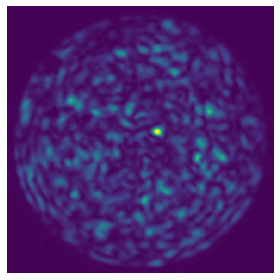

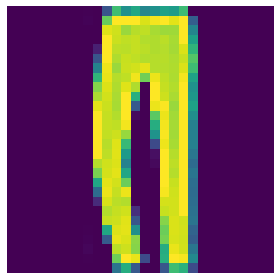

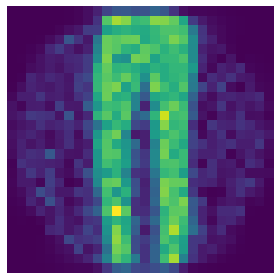

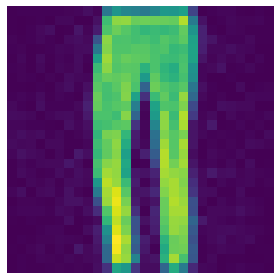

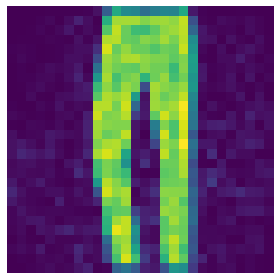

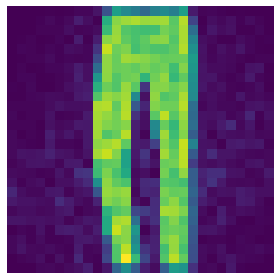

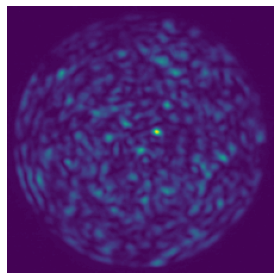

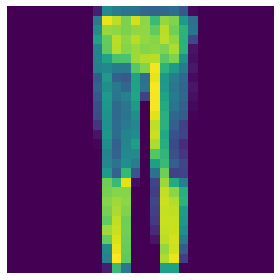

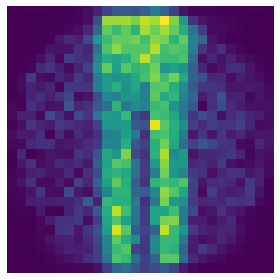

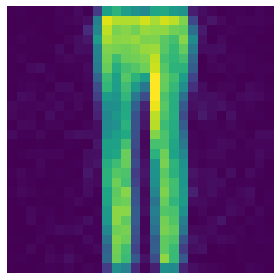

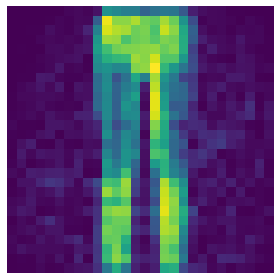

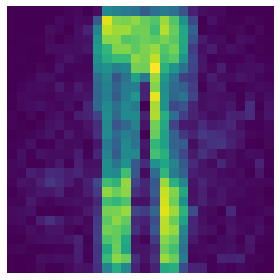

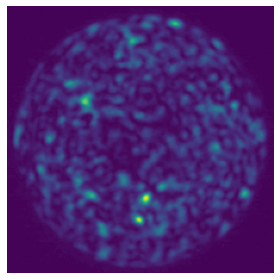

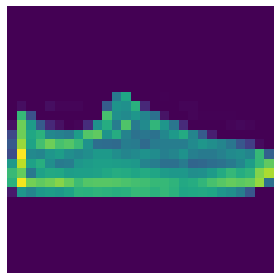

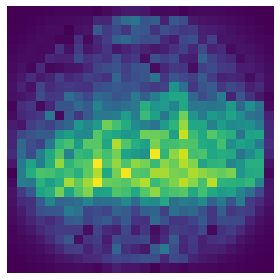

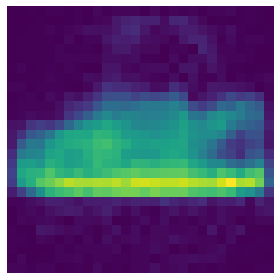

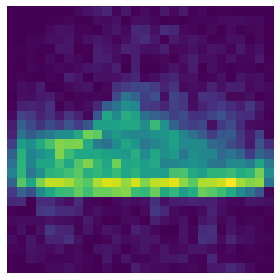

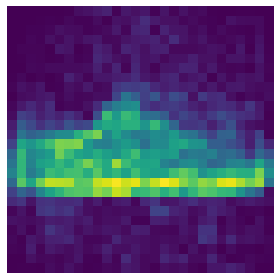

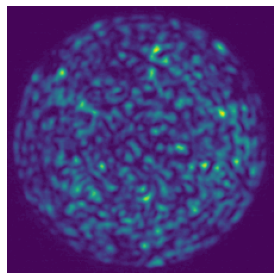

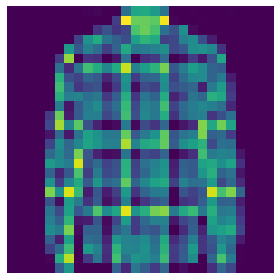

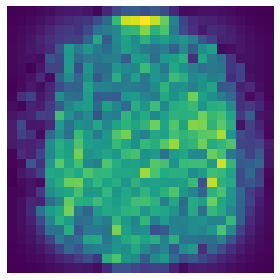

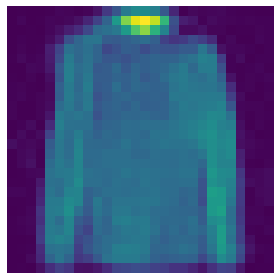

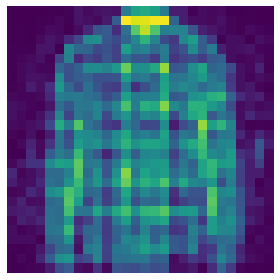

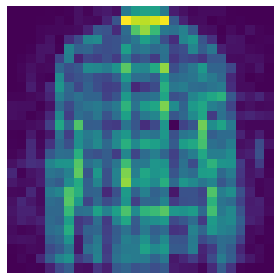

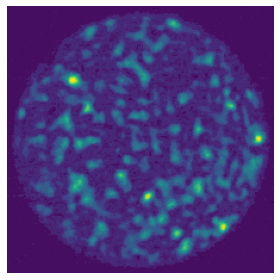

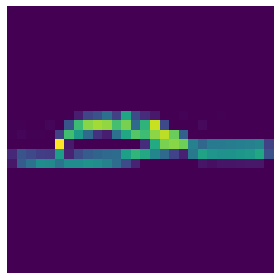

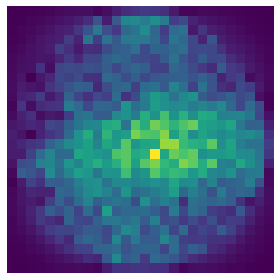

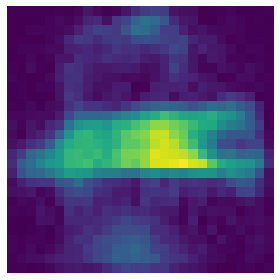

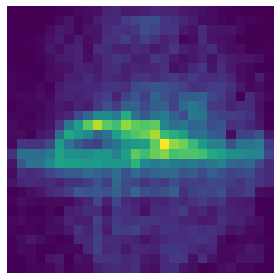

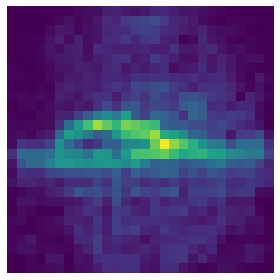

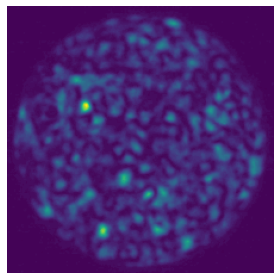

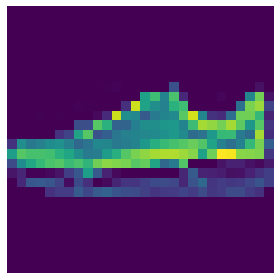

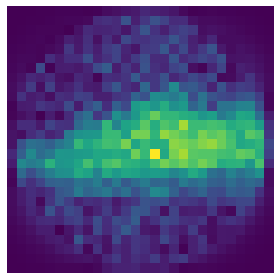

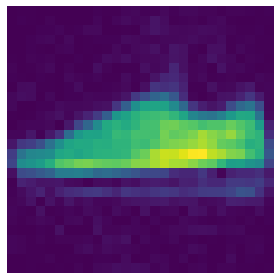

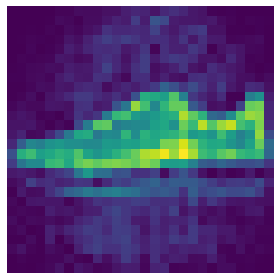

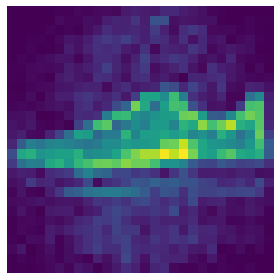

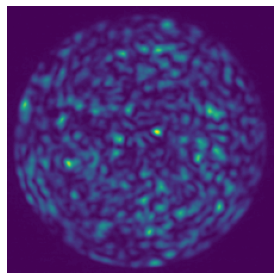

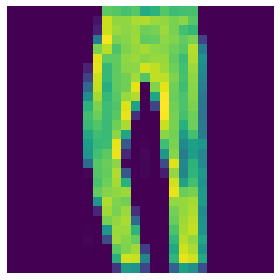

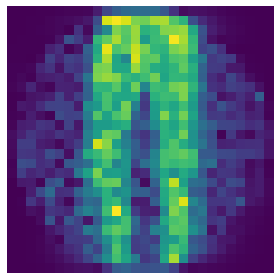

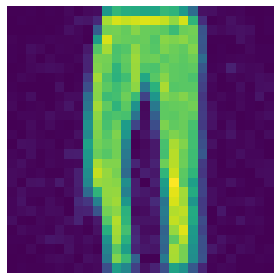

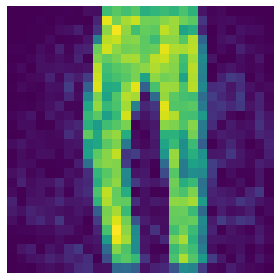

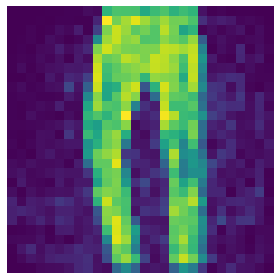

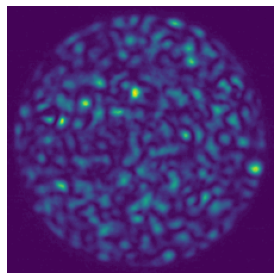

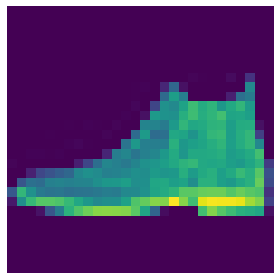

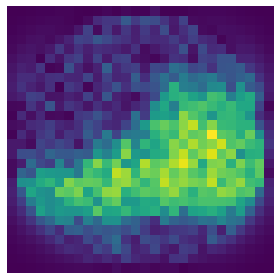

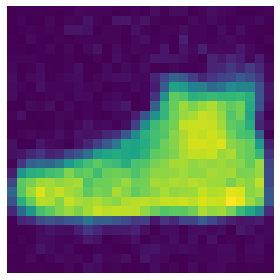

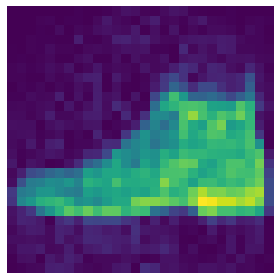

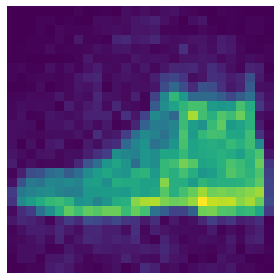

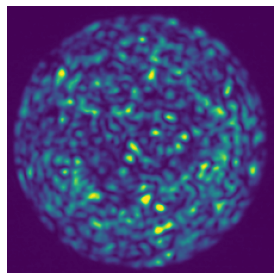

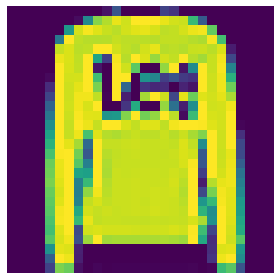

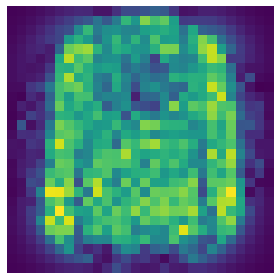

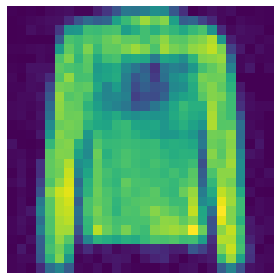

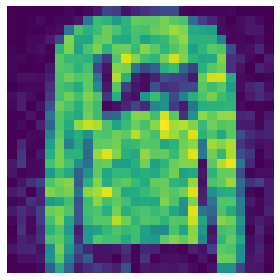

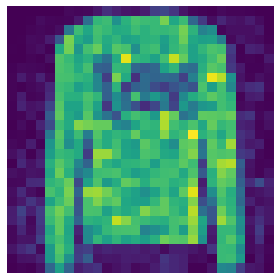

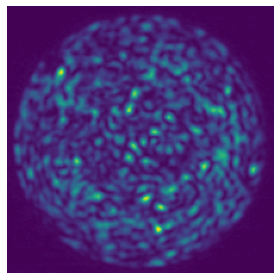

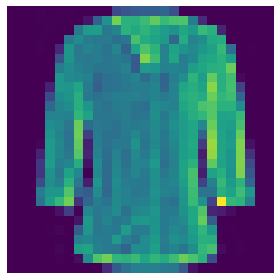

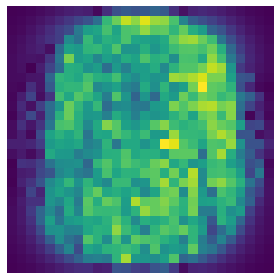

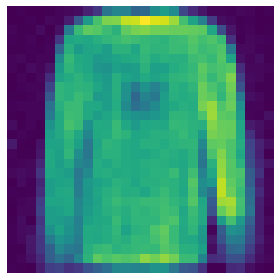

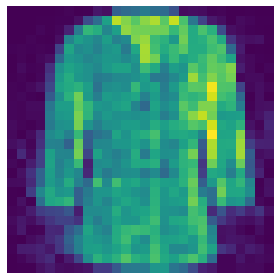

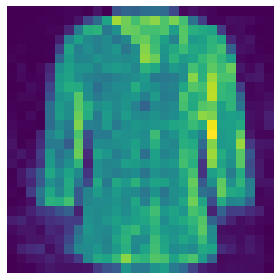

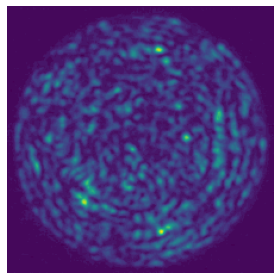

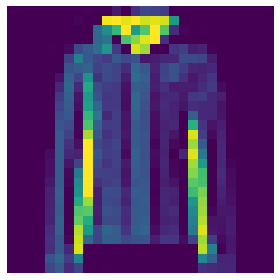

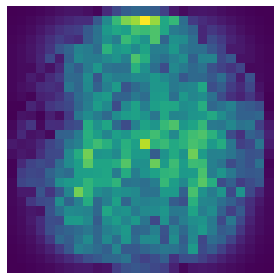

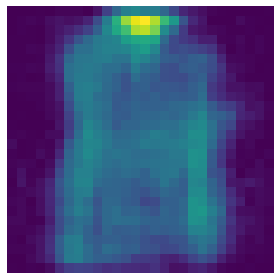

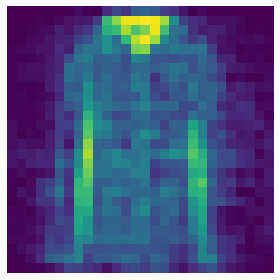

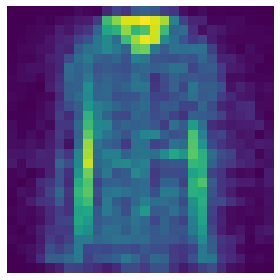

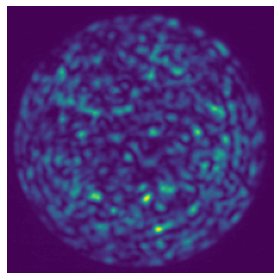

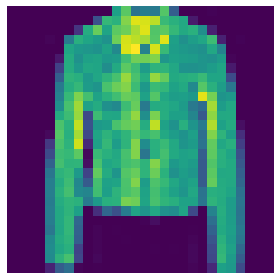

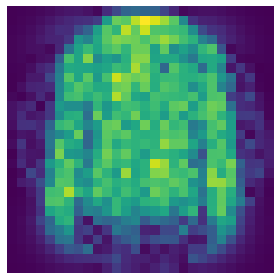

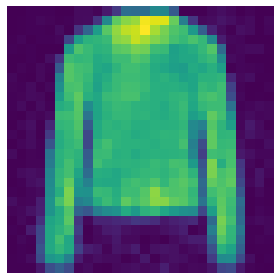

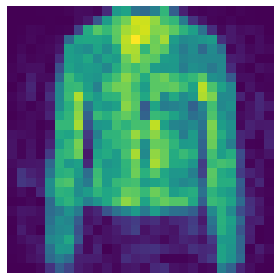

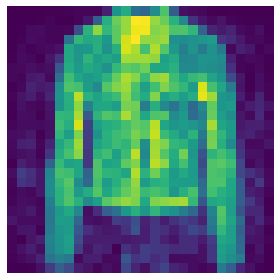

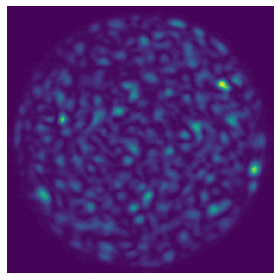

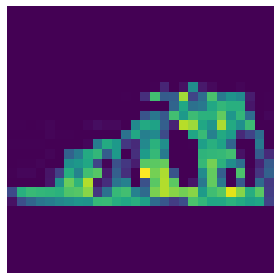

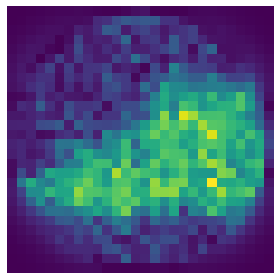

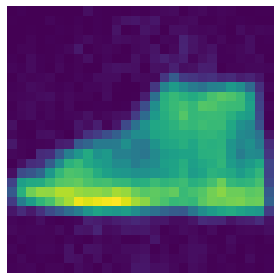

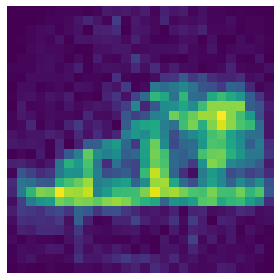

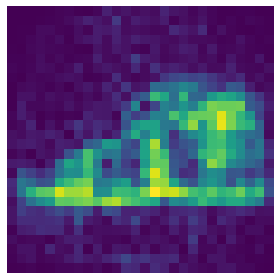

In [15]:
img_nums = [2,3,12,7,8,9,5,0,1,4,6,10,11]
for i, img_num in enumerate(img_nums):
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=0)

    speckled_img = torch.unsqueeze(speckled_img, dim=1)
    original_img = torch.unsqueeze(original_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)

    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_inv_img = torch.abs(predicted_inv_img)
    
    predicted_inv_img = predicted_inv_img.view(-1,1,28,28)
    predicted_img = mod_SR(predicted_inv_img)#.cpu()
    
    predicted_inv_img_mlp = mod_mlp(speckled_img)
    predicted_inv_img_cmlp = mod_cmlp(speckled_img)

    speckled_img = speckled_img.view(224,224).detach().cpu().numpy()
    original_img = original_img.view(28,28).detach().cpu().numpy()
    predicted_inv_img = predicted_inv_img.view(28,28).detach().cpu().numpy()
    predicted_img = predicted_img.view(28,28).detach().cpu().numpy()
    predicted_inv_img_mlp = predicted_inv_img_mlp.view(28,28).detach().cpu().numpy()
    predicted_inv_img_cmlp = predicted_inv_img_cmlp.view(28,28).detach().cpu().numpy()

    fig = plt.figure()
    plt.imshow(np.abs(speckled_img), vmin=np.min(np.abs(speckled_img)), vmax=np.max(np.abs(speckled_img)))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/real_imgs_fmnist/speckled_{i}.pdf', bbox_inches='tight', pad_inches=0)

    fig = plt.figure()
    plt.imshow(original_img, vmin=np.min(original_img), vmax=np.max(original_img))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/real_imgs_fmnist/original_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(np.abs(predicted_inv_img), vmin=np.min(np.abs(predicted_inv_img)), vmax=np.max(np.abs(predicted_inv_img)))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/real_imgs_fmnist/TM_bases_full_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(np.abs(predicted_img), vmin=np.min(np.abs(predicted_img)), vmax=np.max(np.abs(predicted_img)))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/real_imgs_fmnist/TM_bases_SR_full_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(np.abs(predicted_inv_img_mlp), vmin=np.min(np.abs(predicted_inv_img_mlp)), vmax=np.max(np.abs(predicted_inv_img_mlp)))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/real_imgs_fmnist/MLP_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(np.abs(predicted_inv_img_cmlp), vmin=np.min(np.abs(predicted_inv_img_cmlp)), vmax=np.max(np.abs(predicted_inv_img_cmlp)))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/real_imgs_fmnist/CMLP_{i}.pdf', bbox_inches='tight', pad_inches=0)
